# Procesamiento de Lenguaje Natural - **Trabajo Práctico 3**
# **Detectando rumores en los medios sociales**

Detectar aquellos tweets que contienen información que todavía no ha sido verificada (los rumores), distinguiéndola de lo que no son rumores!



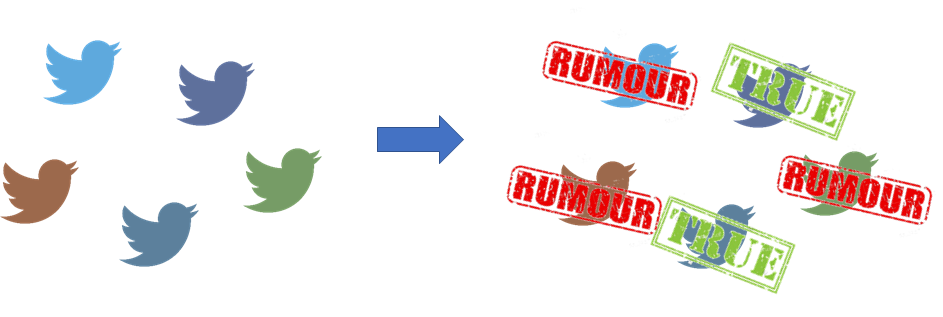

### Qué tienen que hacer?


1.    Pre-procesamiento. Selección de features léxicas.
2.    Features sintácticas & Pipeline.
**3.    Modelo de clasificación.**

Con los prácticos anteriores deberían haber integrado:
* Procesamiento de los json con los tweets y almacenarlos en alguna estructura.
* Elección de las características para representar los tweets.
* Elección de la representación para los tweets. 

Ahora, para este práctico:

* Entrenar modelos de clasificación de rumores!

* Elegir una técnica de selección de características para aplicar.
* Elegir al menos dos clasificadores para entrenar.
  * Realizar optimización de parámetros.
* Reportar resultados la clasificación con los diferentes clasificadores:
  * Aplicando o no pre-procesamiento.
  * Aplicando o no feature selection (sobre la variante con pre-procesamiento).




## Carga del dataset

El código que hayan utilizado en el práctico anterior para la obtención de los datos y crear la primera representación de los tweets. Recordar que la notebook debe poder ejecutarse sin errores.

In [ ]:
!pip install unidecode
!pip install contractions
!pip install spacy

import sys
import time
import requests
import urllib.request
import os
import json
import pandas as pd
import gzip
import shutil
from zipfile import ZipFile
from datetime import datetime
import re
import contractions
import nltk
import spacy
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from unidecode import unidecode
from IPython.display import clear_output
from collections import Counter
import string
from nltk.data import load
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

!git clone https://github.com/LuchoTangorra/DUIA-NLP.git
!git pull

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
fatal: destination path 'DUIA-NLP' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
datapath = r"/content/DUIA-NLP/sydneysiege-opcion3.zip"
print("Extracting data...")
with ZipFile(datapath, 'r') as zipObj:
    zipObj.extractall('.')

def json_to_df(json_path):
  with open(json_path) as json_file:
    jarray = json.load(json_file)

  df_aux = list()
  for item in jarray:
      df_aux.append(item)

  jsondf = pd.DataFrame(df_aux)
  jsondf = jsondf.set_index('id') # seteamos el id como index del frame
  return jsondf

filepath = "sydneysiege-opcion3/tweets.json"
df = json_to_df(filepath).reset_index(drop=False)
df = df.set_index('id')

Extracting data...


### Preparing input

El bloque de pre procesamiento siguiente es solo copy paste de lo que hice en el TP2 y para mostrar los resultados que me daba. Luego lo hice un poco mas limpio con pipeline.

El problema del sentiment analysis en el tp anterior, que me daba todo 0, era porque me habia olvidado un valor como True y eso rompia la oracion. Le saque ese valor y anda joya, disculpa!



In [ ]:
tfidf = TfidfVectorizer()

def apply_tfidf(df, tfidf=None, min_df=30):
  '''
  Se aplica tfidf con una cantidad de frecuencia minima de 
  30 documentos, con el objetivo de reducir la cantidad de features.
  '''
  out = df.copy()

  start = time.time()
  train = False
  if tfidf is None:
    train = True
    tfidf = TfidfVectorizer(min_df=min_df)
    tfidf_matrix = tfidf.fit_transform(out['text'])
    tfidf_matrix = tfidf_matrix.toarray()
  else:
    tfidf_matrix = tfidf.transform(out['text']) 
    tfidf_matrix = tfidf_matrix.toarray()

  vocab = tfidf.get_feature_names()
  tfidf_matrix = pd.DataFrame(tfidf_matrix, columns=vocab)
  end = time.time()
  print("Time transforming to tf-idf: ", end - start)

  if train:
    return out.merge(tfidf_matrix, left_index=True, right_index=True), tfidf
  else:
    return out.merge(tfidf_matrix, left_index=True, right_index=True)

def prepare_rumour_column(rumour):
  '''
  Preparamos la columna target (rumour) con valores numericos
  para que sean reconocidos por el modelo. 
  '''
  if rumour == 'yes':
    return 1
  else:
    return 0

def prepare_user_verified_column(row):
  '''
  Preparamos la columna user verified realizando one hot encoding.
  '''
  if row['user_verified'] == True:
    row['user_verified_true'] = 1
  else:
    row['user_verified_false'] = 1
  return row

def prepare_categorical_data(df):
  '''
  Aplicamos preprocesamiento a las columnas categoricas para que
  sean utiles para los modelos. Estas columnas son rumour y
  user verified.
  '''
  out = df.copy()
  start = time.time()
  out['rumour'] = out['rumour'].apply(lambda x: prepare_rumour_column(x))
  out['user_verified_true'] = 0
  out['user_verified_false'] = 0
  out = out.apply(lambda x: prepare_user_verified_column(x), axis=1)
  out.drop('user_verified', axis=1, inplace=True)
  end = time.time()
  print("Time transforming categorical data: ", end - start)

  return out

def normalize_columns(df, normalize_sums=None, columns=['favorite_count', 'retweet_count', 'user_followers']):
  '''
  Normalizamos las columnas que tienen valores elevados, dividiendolas por el valor maximo de la misma.
  Esto se realiza con el objetivo de no tener valores demasiado elevados ya que podrian perjudicar la 
  performance de algunos modelos.
  '''
  out = df.copy()

  train = False
  if normalize_sums is None:
    train = True
    normalize_sums = {}    

  start = time.time()
  for c in columns:
    #Para futuros inputs tengo que guardar este valor, es solo para train el calculo
    if train:
      normalize_sums[c] = out[c].max()
    out[c] = out[c] / normalize_sums[c]

  end = time.time()
  print("Time normalizing data: ", end - start)
  if train:
    return out, normalize_sums
  else:
    return out

nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk_stopwords.extend(["co","http","sydneysiege","sydney","hostages","police","hostage","people", 'breaking'])
sid = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_sm")
clear_output()

def remove_websites(text, startWith='http'):
  '''
  Se remueven los sitios web de los tweets (iniciando con http y www).
  '''
  try:
    out = text
    while (True):
      http_index = out.index(startWith)
      try:
        end_http_index = out[http_index:].index(" ") + http_index
      except:
        end_http_index = len(out)
      out = out[:http_index] + out[end_http_index:]
  except:
    return out

def remove_special_characters(text):
  '''
  Se mantienen solo las letras en el texto.
  '''
  pattern = r'[^a-z\s]'
  text = re.sub(pattern, '', text)
  return text

def remove_stopwords(text):
  '''
  Se eliminan los stopwords (nltk+agregados)
  '''
  text_no_stopwords = [w for w in text.split() if not w in nltk_stopwords]
  return ' '.join(text_no_stopwords)

def remove_accent_mark(text, words=None):
  ''' 
  Se eliminan las tildes de las palabras elegidas
  '''
  out = []
  if words is None:
    return
  for w in text.split():
    if w in words:
      out.append(unidecode(w))
    else:
      out.append(w)
  return ' '.join(out)

#Feature agregada
def sentiment_value(text, is_list=False):
  ''' 
  Usamos NLTK vader ya que se dice que es mejor para texto
  de redes sociales. Obtenemos solamente el compound.
  '''
  if is_list:
    text = ' '.join(text)
  polarity_score = sid.polarity_scores(text)
  return polarity_score['compound']

#Feature agregada
def pos_counter(df, is_list=True):
  '''
  Creo las nuevas features (pueden ser varias) y les asigno los
  valores correspondientes segun el texto.
  '''
  out = df.copy()

  tagdict = load('help/tagsets/upenn_tagset.pickle')
  pos_labels = list(tagdict.keys())
  pos_labels.append('#')  

  if is_list:
    out['text'].apply(lambda x: ' '.join(x))
    
  for label in pos_labels:
    out[label] = 0

  def set_pos_labels_count(row):
    '''
    Cuento los valores de cada pos encontrado y los pongo
    en el dataframe.
    '''
    def get_pos_tags(text):
      pos_tags = []
      for word in nltk.word_tokenize(text):
        pos = nltk.pos_tag([word])[0][1]
        pos_tags.append(pos)
      return pos_tags

    count_labels = Counter(get_pos_tags(row['text']))
    for key in count_labels.keys():
      row[key] = count_labels[key]
    return row

  out = out.apply(lambda x: set_pos_labels_count(x), axis=1)

  return out

#Feature modificada, anteriormente era stemming
def lemmatize_text(text, is_list=False):
  '''
  Internamente spaCy usa etiquetado POS. Otra opción 
  es utilizar NLTK y hacer a mano el etiquetado POS (con 
  alguna libreria).

  Anteriormente se realizo stemming pero con lo que se aprendió
  de lemmatización se optó por esta opción.
  '''
  if is_list:
    text = ' '.join(text)
  
  doc = nlp(text)
  lemmatized = ''
  for word in doc:
    if not word.lemma_.startswith('-') :
        lemmatized += word.lemma_ + ' '
  
  return lemmatized

def pre_processing_pipeline(df, lemmatize=True, delete_stopwords=True):
  out = df.copy()

  start = time.time()
  out = out[['text', 'user', 'created_at', 'favorite_count', 'retweet_count', 'rumour']]
  
  #Nos quedamos solo con el verified del usuario y con la cantidad de seguidores que tenga la acc.
  out['user_verified'] = out['user'].apply(lambda x: x['verified'])
  out['user_followers'] = out['user'].apply(lambda x: x['followers_count'])
  out.drop('user', axis=1, inplace=True)
  
  #Del created_at nos quedamos unicamente con la hora en el que se realizó el tweet
  out['created_at'] = out['created_at'].apply(lambda x: datetime.strptime(x[:-11], '%a %b %d %H:%M:%S').time().hour)
  end = time.time()
  print("Time selecting features: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_websites(x))
  out['text'] = out['text'].apply(lambda x: remove_websites(x, startWith='www'))
  end = time.time()
  print("Time removing websites: ", end - start)
  
  #Feature agregada
  start = time.time()
  out = pos_counter(out)
  end = time.time()
  print("Time counting POS labels: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: x.lower())
  end = time.time()
  print("Time setting to lowercase: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
  out['text'] = out['text'].apply(lambda x: ' '.join(x))
  end = time.time()
  print("Time fixing contractions: ", end - start)

  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_special_characters(x))
  end = time.time()
  print("Time removing special characters: ", end - start)

  #Eliminamos las tildes en café y cafés.
  start = time.time()
  out['text'] = out['text'].apply(lambda x: remove_accent_mark(x, ['café', 'cafés']))
  end = time.time()
  print("Time removing accent marks in café and cafés: ", end - start)

  #Se elimino el spell check ya que demora mucho tiempo.

  #Feature agregada
  start = time.time()
  out['word_count'] = out['text'].apply(lambda x: len(x))
  end = time.time()
  print("Time counting words: ", end - start)

  if delete_stopwords:
    start = time.time()
    out['text'] = out['text'].apply(lambda x: remove_stopwords(x))
    end = time.time()
    print("Time removing stopwords: ", end - start)

  #Feature agregada
  start = time.time()
  out['sentiment'] = out['text'].apply(lambda x: sentiment_value(x))
  end = time.time()
  print("Time analizing sentiment: ", end - start)

  #Feature modificada, anteriormente era stemming
  if lemmatize:
    start = time.time()
    out['text'] = out['text'].apply(lambda x: lemmatize_text(x))
    end = time.time()
    print("Time lemmatizing: ", end - start)

  return out

In [ ]:
#prero func
def prepare_input(df, train=True, tfidf=None, values_to_normalize=None):
  '''
  En caso de ser entrenable hay que pasarle los modelos de tfidf y las sumas
  ya realizadas.
  En caso de que se desee entrenar se retornan el modelo de tfidf y 
  un arreglo con los valores para normalizar. Estos se deben guardar para
  cuando se desee aplicar el preprocesamiento a los datos de val/test.
  '''
  if not train and tfidf is None and values_to_normalize is None:
    print("Se necesita el modelo tfidf y el vector de sumas para normalizar :)")
    return 
  start = time.time()
  out = df.copy()
  out = out.reset_index(drop=True)
  
  out = pre_processing_pipeline(out)
  if train:
    out, tfidf = apply_tfidf(out)
  else:
    out = apply_tfidf(out, tfidf)
  out = prepare_categorical_data(out)
  if train:
    out, values_to_normalize = normalize_columns(out)
  else:
    out = normalize_columns(out, values_to_normalize)
  out.drop('text', axis=1, inplace=True)
  end = time.time()
  print("Total time pre processing: ", end - start)

  if train:
    return out, tfidf, values_to_normalize
  else:
    return out

In [ ]:
df_preprocessed, tfidf, values_to_normalize = prepare_input(df)

Time selecting features:  0.03022313117980957
Time removing websites:  0.004706621170043945
Time counting POS labels:  3.376037120819092
Time setting to lowercase:  0.001535177230834961
Time fixing contractions:  0.060025691986083984
Time removing special characters:  0.004458189010620117
Time removing accent marks in café and cafés:  0.00507807731628418
Time counting words:  0.001611948013305664
Time removing stopwords:  0.03516387939453125
Time analizing sentiment:  0.15001201629638672
Time lemmatizing:  10.8443603515625
Time transforming to tf-idf:  0.016576766967773438
Time transforming categorical data:  0.22757935523986816
Time normalizing data:  0.09281015396118164
Total time pre processing:  14.867787837982178


In [ ]:
df_preprocessed

,created_at,favorite_count,retweet_count,rumour,user_followers,LS,TO,VBN,'',WP,UH,VBG,JJ,VBZ,--,VBP,NN,DT,PRP,:,WP$,NNPS,PRP$,WDT,(,),.,",",``,$,RB,RBR,RBS,VBD,IN,FW,RP,JJR,JJS,PDT,...,evacuate,flag,get,go,gunman,hold,hour,illridewithyou,inside,isis,islamic,know,lindt,live,man,martin,martinplace,medium,muslim,muslims,news,one,place,pm,pray,prayer,report,run,say,see,show,siege,situation,storm,take,thought,update,window,user_verified_true,user_verified_false
0,23,0.000361,0.004471,1,0.000073,0,1,1,0,0,0,1,0,0,0,1,10,3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,...,0.0,0.315761,0.0,0.0,0.000000,0.303479,0.0,0.0,0.000000,0.382523,0.0,0.0,0.333085,0.0,0.365903,0.364396,0.0,0.0,0.0,0.0,0.325952,0.0,0.354493,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1,23,0.000080,0.001497,1,0.000092,0,0,0,0,0,0,0,0,1,0,0,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.413407,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.503834,0.0,0.0,0.0,0.0,0.000000,0.0,0.490142,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.48470,0.0,0.000000,0.000000,1,0
2,23,0.000260,0.002030,1,0.001175,0,0,0,0,0,0,1,0,1,0,0,12,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,...,0.0,0.318532,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.385879,0.0,0.0,0.000000,0.0,0.000000,0.367593,0.0,0.0,0.0,0.0,0.328812,0.0,0.357603,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.301618,0.0,0.000000,0.00000,0.0,0.349827,0.406399,1,0
3,23,0.000060,0.001085,1,0.006593,0,0,0,0,0,0,2,0,1,0,1,10,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.288946,0.0,0.0,0.000000,0.000000,0.0,0.0,0.317134,0.0,0.000000,0.346945,0.0,0.0,0.0,0.0,0.000000,0.0,0.675033,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.284676,0.0,0.000000,0.33377,0.0,0.000000,0.000000,1,0
4,23,0.000561,0.006682,1,0.000073,0,0,0,0,0,0,1,0,1,0,0,9,2,0,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,...,0.0,0.329658,0.0,0.0,0.000000,0.316835,0.0,0.0,0.420594,0.399358,0.0,0.0,0.000000,0.0,0.000000,0.380433,0.0,0.0,0.0,0.0,0.340297,0.0,0.370094,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,15,0.000120,0.001005,0,0.130875,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.426127,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.545124,0.0,0.0,0.0,0.382514,0.0,0.537833,0.00000,0.0,0.000000,0.000000,1,0
1217,15,0.002103,0.004913,0,0.202441,0,1,0,0,0,0,2,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1218,15,0.000608,0.001819,0,0.085378,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,1,0
1219,15,0.000234,0.001176,0,0.001578,0,0,1,0,0,0,0,0,1,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.741224,0.00000,0.0,0.000000,0.000000,1,0


## Preparado de los datos para la utilización del modelo de clasificación

*Código integrando la creación de la representación de los tweets que hayan hecho en el práctico anterior + la técnica de feature selection elegida. Explicar la elección de la técnica*

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

Se aplica preprocesamiento de los datos. No se utilizo pipeline por temas de tiempo (entendi como utilizarlo recien en este tp).

In [ ]:
def prepro(df):
  df_prepro = df.copy().reset_index(drop=True)
  df_prepro = pre_processing_pipeline(df_prepro)
  df_prepro = prepare_categorical_data(df_prepro)
  df_prepro_targets = df_prepro['rumour']
  df_prepro.drop('rumour', inplace=True, axis=1)
  return df_prepro, df_prepro_targets

In [ ]:
df_prepro, df_prepro_targets = prepro(df)

Time selecting features:  0.025257349014282227
Time removing websites:  0.004251956939697266
Time counting POS labels:  3.2445077896118164
Time setting to lowercase:  0.0015490055084228516
Time fixing contractions:  0.05464577674865723
Time removing special characters:  0.004132747650146484
Time removing accent marks in café and cafés:  0.004764080047607422
Time counting words:  0.0016121864318847656
Time removing stopwords:  0.034697532653808594
Time analizing sentiment:  0.15253353118896484
Time lemmatizing:  10.779649257659912
Time transforming categorical data:  0.20802688598632812


Se plantean cuatro modelos de features selection para realizar una votacion final y quedarnos con las features que mas votos tengan. En este primer caso no se toma en cuenta el Tfidf ya que luego se separarán los datos en train/test (por cross-val) y será diferente en cada caso. 

Se tomaron en cuenta cuatro metodos de feature selection:

- RFE con Regresion Logistica: Recursive Feature Elimination se encarga de considerar cada vez menos features hasta llegar a considerar solamente la mitad. Para considerar esto se fija en los coeficientes de un modelo lineal como lo es la regresion logistica y elimina la feature que sea menos importante (que impacte en menor modo al resultado).

- Lasso: lasso es un modelo lineal que, por el tipo de regularizacion que utiliza (l1), realiza feature selection automatico (algunos coeficientes quedan como 0).

- Random Forest: Son muy usados para seleccionar features ya que la estrategia que utiliza para armar los nodos rankea las features que mas le sirven para disminuir la gini impurity.

- SelectKBest con Mutual Info: Mutual info mide el grado de dependencia o linearidad entre dos features. Valor 0 mide independencia mientras que valores altos miden dependencia. SelectKBest agarra las 10 mejores features (por defecto).

In [ ]:
feature_selection_models = [RFE(estimator=LogisticRegression(max_iter=500)),
                            SelectFromModel(Lasso()), 
                            SelectFromModel(RandomForestClassifier(n_estimators=100)),
                            SelectKBest(mutual_info_classif)]

In [ ]:
preprocessor = ColumnTransformer(
  transformers=[
              ('normalization', Normalizer('max'), ['favorite_count', 'retweet_count', 'user_followers'])
              ], 
              remainder='passthrough')

In [ ]:
df_prepro_no_text = df_prepro.copy()
df_prepro_no_text.drop('text', axis=1, inplace=True)

In [ ]:
pipelines = []

for model in feature_selection_models:
  pipeline = Pipeline(steps=[
                             ('preprocessor', preprocessor),
                             ('feature_sel', model)
                            ])

  pipeline = pipeline.fit(df_prepro_no_text, df_prepro_targets)

  pipelines.append(pipeline)
  clear_output()

In [ ]:
'''
Pongo las features elegidas por cada modelo en un dataframe y realizo la suma.
Luego los muestro y me quedo solo con los que tienen mas de la mitad de los votos.
'''
supports = pd.DataFrame(columns=['feature_name','RFE','Lasso','RFC','mut_inf','total'])
supports['RFE'] = pipelines[0]['feature_sel'].get_support()
supports['Lasso'] = pipelines[1]['feature_sel'].get_support()
supports['RFC'] = pipelines[2]['feature_sel'].get_support()
supports['mut_inf'] = pipelines[3]['feature_sel'].get_support()
supports['total'] = supports.apply(lambda x: x.sum(), axis=1)
supports['feature_name'] = df_prepro_no_text.columns.values
supports = supports.sort_values(by='total', ascending=False)
print(supports.shape)
display(supports)

(54, 6)


,feature_name,RFE,Lasso,RFC,mut_inf,total
0,created_at,True,False,True,True,3
51,sentiment,True,False,True,True,3
1,favorite_count,True,False,True,True,3
17,PRP,True,False,True,True,3
16,DT,False,False,True,True,2
52,user_verified_true,True,False,False,True,2
50,word_count,False,True,True,False,2
47,CD,True,False,True,False,2
18,:,True,False,True,False,2
53,user_verified_false,True,False,False,True,2


In [ ]:
usefull_params = supports.loc[supports['total'] > 1]
print("Shape:   ", usefull_params.shape)
print("")
display(usefull_params)

Shape:    (11, 6)



,feature_name,RFE,Lasso,RFC,mut_inf,total
0,created_at,True,False,True,True,3
51,sentiment,True,False,True,True,3
1,favorite_count,True,False,True,True,3
17,PRP,True,False,True,True,3
16,DT,False,False,True,True,2
52,user_verified_true,True,False,False,True,2
50,word_count,False,True,True,False,2
47,CD,True,False,True,False,2
18,:,True,False,True,False,2
53,user_verified_false,True,False,False,True,2


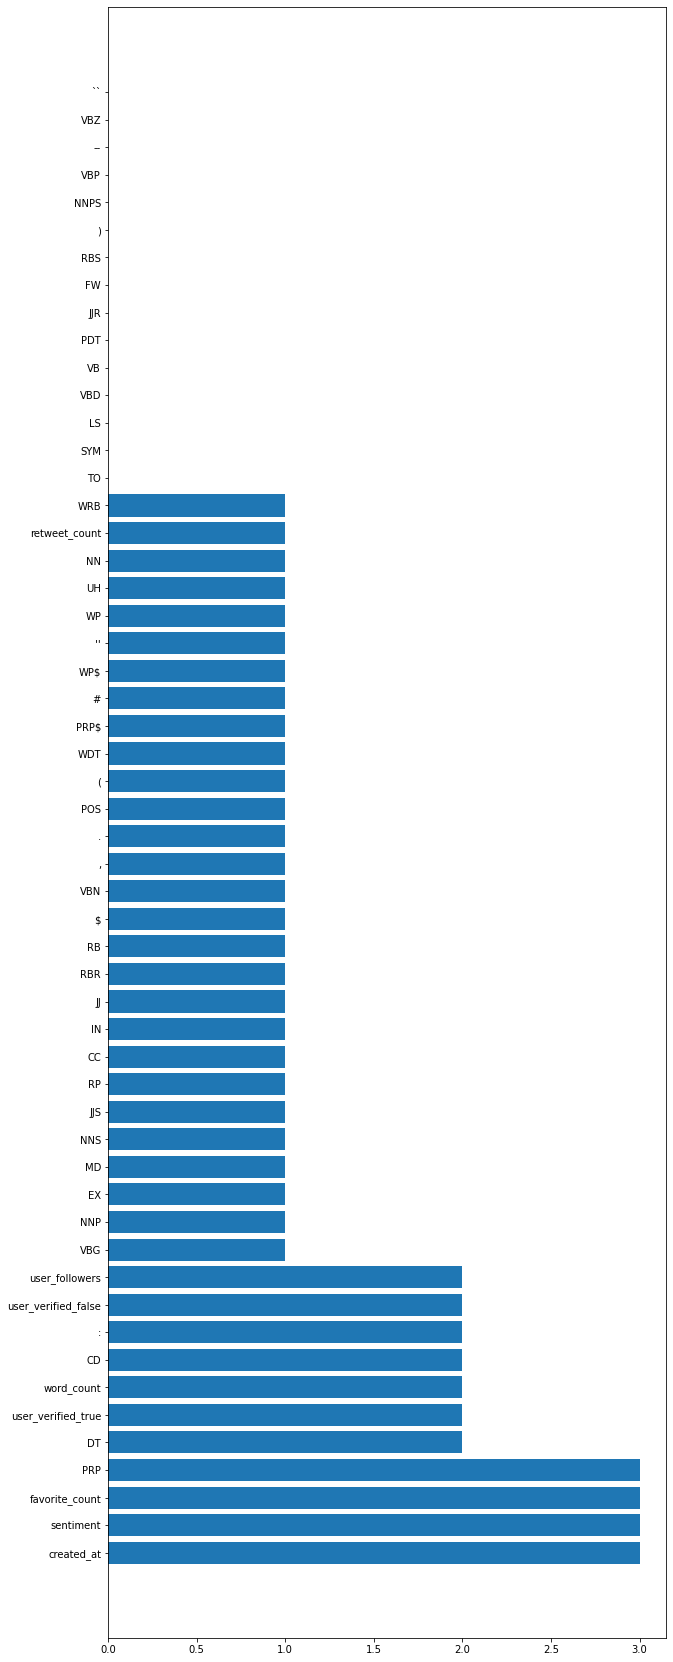

In [ ]:
plt.figure(figsize=(10,30))
plot = plt.barh(supports['feature_name'], supports['total'])

In [ ]:
df_prepro_no_text.iloc[:, list(usefull_params.index)]

,created_at,sentiment,favorite_count,PRP,DT,user_verified_true,word_count,CD,:,user_verified_false,user_followers
0,23,-0.4588,54,0,3,1,132,1,1,0,1672
1,23,0.0000,12,0,0,1,61,0,1,0,2114
2,23,0.0000,39,0,3,1,102,1,1,0,26903
3,23,0.0000,9,0,1,1,107,0,1,0,150994
4,23,0.0000,84,0,2,1,131,0,2,0,1672
...,...,...,...,...,...,...,...,...,...,...,...
1216,15,0.0000,18,0,0,1,65,0,0,0,2997545
1217,15,0.0000,315,0,0,1,53,0,1,0,4636658
1218,15,0.0000,91,0,0,1,72,0,0,0,1955488
1219,15,0.0000,35,0,1,1,87,0,1,0,36137


Se pueden observar las features que fueron seleccionadas y su importancia, tanto en formato df como en un grafico de barras horizontal.

Pasamos de 54 features a 10 features (sin contar las que se van a generar con tfidf), esto nos demuestra que habia muchas features que (segun lo planteado) no aportaban informacion valiosa al modelo.

pd: TENGO DUDAS DE SI ESTA BIEN AGARRAR EL DF ORIGINAL PARA OBTENER LOS NOMBRES DE LAS FEATURES O SI POR ALGUN MOTIVO SE MODIFICAN.

## Modelos de clasificación

*Entrenamiento de los clasificadores elegidos + optimización de parámetros.
Explicar brevemente la elección de los clasificadores.*

Realizo Grid Search para buscar los mejores hiperparametros realizando cross validation con 5 folds (250 de test datos y el resto de train aprox). Por cada cross val que aplico, realizo tfid y normalization y luego hago un feature selection con los 4 algoritmos mostrados anteriormente. Hay que tener en cuenta que no se van a utilizar las mismas features que las que se mostraron anteriormente ya que se incluyen las features de tfidf. Para realizar feature selection se implemento un transformer que realiza la logica de correr los 4 modelos y se queda con las features mas votadas.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Transformer de feature selection segun los 4 algoritmos planteados
#anteriormente, siguiendo un criterio de votacion.
class FeatureSelector(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.feature_sel_mod = []
    self.support = pd.DataFrame()
    self.usefull_params = pd.DataFrame()

  def fit(self, X, y = None):
    for i, model in enumerate(feature_selection_models):
      self.feature_sel_mod.append(model.fit(X, y))
      self.usefull_params[i] = 0
      self.support[i] = 0
    self.support[i+1] = 0
    self.usefull_params[i+1] = 0
    for i, feature_sel in enumerate(self.feature_sel_mod):
      self.support[i] = feature_sel.get_support()
    self.support[i+1] = self.support.apply(lambda x: x.sum(), axis=1)
    self.usefull_params = self.support.loc[self.support[i+1] > 1]
    return self

  def transform(self, X, y = None):
    return X[:, list(usefull_params.index)]

In [ ]:
#Pre processor con tfidf y  normalizer
df_prepro, df_prepro_targets = prepro(df)

preprocessor = ColumnTransformer(
  transformers=[
    ('tfidf', TfidfVectorizer(min_df=30), 'text'),
    ('normalization', Normalizer('max'), ['favorite_count', 'retweet_count', 'user_followers'])], 
    remainder='passthrough')

Time selecting features:  0.023326873779296875
Time removing websites:  0.004421234130859375
Time counting POS labels:  3.405369758605957
Time setting to lowercase:  0.0015513896942138672
Time fixing contractions:  0.05489802360534668
Time removing special characters:  0.004276752471923828
Time removing accent marks in café and cafés:  0.005396366119384766
Time counting words:  0.0018165111541748047
Time removing stopwords:  0.0344390869140625
Time analizing sentiment:  0.1617121696472168
Time lemmatizing:  10.356349229812622
Time transforming categorical data:  0.19602441787719727


In [ ]:
#Antes de entrenar los predictores tomamos los pesos de la clase (para forzar
#el mayor balance posible) y entrenamos.
classes = [0, 1]
class_weight = compute_class_weight('balanced', classes, df_prepro_targets)
class_weight = {classes[0]: class_weight[0],
                classes[1]: class_weight[1]}

Se plantearon los modelos mas conocidos de ML para clasificación. Random forest es muy robusto ya que posee varios arboles de decision y entrena con diferentes datos y features cada uno (modelo no lineal), regresion logistica es un modelo simple lineal, SVC segun el kernel que se utilice puede encontrar diferentes patrones en los datos y KNN se fija en los vecinos cercanos (la cantidad o la distancia que tengan) para ver a que clase pertenece.

In [ ]:
prediction_models = [RandomForestClassifier(class_weight=class_weight),
                     LogisticRegression(class_weight=class_weight),
                     SVC(class_weight=class_weight),
                     KNeighborsClassifier()]

feature_selection_models = [RFE(estimator=LogisticRegression(class_weight=class_weight)),
                            SelectFromModel(Lasso()), 
                            SelectFromModel(RandomForestClassifier(class_weight=class_weight)),
                            SelectKBest(mutual_info_classif)]

model_params = [{'n_estimators': [2, 20, 60, 120, 200, 500],
                 'min_samples_split': [150, 100 , 50, 25, 10, 5]}
                ,
                 {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                  'C': [0.05, 0.1, 0.5, 1., 5.],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
                ,
                {
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [0.05, 0.1, 0.5, 1., 5.],
                  'max_iter': [50, 100, 200, 500, 1000]
                },
                {
                  'n_neighbors': [2, 10, 40],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree', 'kd_tree', 'brute']
                }
                ]

In [ ]:
#Antes de realizar cross val separamos en train y test para asi podemos
#ver los resultados en datos nunca antes observados por los modelos
x_train, x_test, y_train, y_test = train_test_split(df_prepro, df_prepro_targets, test_size=0.2, shuffle=True, stratify=df_prepro_targets)

In [ ]:
best_params = []
pipelines = []
k_fold = StratifiedKFold(n_splits=5, shuffle=True)

for i, model in enumerate(prediction_models):
  print("Iteration:", i)
  search = GridSearchCV(model, model_params[i], cv=k_fold)
  prepro_pipeline = Pipeline(
                    steps=[
                      ('preprocessor', preprocessor),
                      ('feature_selector', FeatureSelector())]
                    )
  
  pipeline = Pipeline(steps=[
                            ('prepro_pipeline', prepro_pipeline),
                            ('model_cv', search)
                            ])

  pipeline = pipeline.fit(x_train, y_train)

  pipelines.append(pipeline)
  clear_output()

Mostramos los mejores parametros para cada modelo en cuestion:

In [ ]:
print('Random forest:       ', pipelines[0]['model_cv'].best_params_)
print('                        best score:', pipelines[0]['model_cv'].best_score_)
print('')
print('Logistic regression: ', pipelines[1]['model_cv'].best_params_)
print('                        best score:', pipelines[1]['model_cv'].best_score_)
print('')
print('SVM:                 ', pipelines[2]['model_cv'].best_params_)
print('                        best score:', pipelines[2]['model_cv'].best_score_)
print('')
print('KNN:                 ', pipelines[3]['model_cv'].best_params_)
print('                        best score:', pipelines[3]['model_cv'].best_score_)

Random forest:        {'min_samples_split': 50, 'n_estimators': 120}
                        best score: 0.7090214547357403

Logistic regression:  {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
                        best score: 0.6884667713239143

SVM:                  {'C': 1.0, 'kernel': 'rbf', 'max_iter': 1000}
                        best score: 0.6823652537938252

KNN:                  {'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'uniform'}
                        best score: 0.6772056514913658


## Reporte de los resultados

*Elegir las métricas que consideren adecuadas. Explicar brevemente su elección.
Incluir algún gráfico comparativo.*


Ahora que ya tengo los modelos entrenados, me quedo con los que dieron mejores resultados en el cross-val y veo que resultados de recall, precision, f1-score y accuracy dan.

Accuracy es la metrica por defecto para los problemas de clasificacion con clases balanceadas. Recall se fija cuantas de la clase i predije correctamente contra cuantas predije como que eran de otra clase (TP/(TP+FN)). Precision se fija cuantas de la clase i predije correctamente contra cuantas predije como que eran de esa clase siendo que eran de otra (TP/(TP+FP)). F1 score es la media armonica entre presicion y recall. El accuracy unicamente sirve cuando hay clases  balanceadas. El recall (para una clase) nos sirve cuando queremos evitar la mayor cantidad de errores al predecir esa clase. La precision (para una clase) nos sirve para cuando queremos evitar que se prediga siempre la misma clase. F1 score es cuando queremos darle igual importancia a la precision y al recall.

Se mostrará los resultados de todas las métricas nombradas, aunque únicamente se compararán accuracy y f1 de todas las representaciones ya que se consideran las mas relevantes.

### Datos preprocesados y feature selection

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
rf_model = pipelines[0]
lr_model = pipelines[1]
svm_model = pipelines[2]
knn_model = pipelines[3]

In [ ]:
print("Random forest")
print(classification_report(y_test, rf_model.predict(x_test)))
pre_fea_rf = []
pre_fea_rf.append(accuracy_score(y_test, rf_model.predict(x_test)))
pre_fea_rf.append(f1_score(y_test, rf_model.predict(x_test)))

Random forest
              precision    recall  f1-score   support

           0       0.78      0.66      0.71       140
           1       0.62      0.75      0.68       105

    accuracy                           0.70       245
   macro avg       0.70      0.70      0.70       245
weighted avg       0.71      0.70      0.70       245



In [ ]:
print("Logistic regression")
print(classification_report(y_test, lr_model.predict(x_test)))
pre_fea_lr = []
pre_fea_lr.append(accuracy_score(y_test, lr_model.predict(x_test)))
pre_fea_lr.append(f1_score(y_test, lr_model.predict(x_test)))

Logistic regression
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       140
           1       0.62      0.75      0.68       105

    accuracy                           0.69       245
   macro avg       0.70      0.70      0.69       245
weighted avg       0.71      0.69      0.70       245



In [ ]:
print("SVM")
print(classification_report(y_test, svm_model.predict(x_test)))
pre_fea_svm = []
pre_fea_svm.append(accuracy_score(y_test, svm_model.predict(x_test)))
pre_fea_svm.append(f1_score(y_test, svm_model.predict(x_test)))

SVM
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       140
           1       0.64      0.68      0.66       105

    accuracy                           0.70       245
   macro avg       0.69      0.70      0.69       245
weighted avg       0.70      0.70      0.70       245



In [ ]:
print("KNN")
print(classification_report(y_test, knn_model.predict(x_test)))
pre_fea_knn = []
pre_fea_knn.append(accuracy_score(y_test, knn_model.predict(x_test)))
pre_fea_knn.append(f1_score(y_test, knn_model.predict(x_test)))

KNN
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       140
           1       0.68      0.57      0.62       105

    accuracy                           0.70       245
   macro avg       0.70      0.69      0.69       245
weighted avg       0.70      0.70      0.70       245



### Datos preprocesados sin features selection

In [ ]:
best_params = []
pipelines = []
k_fold = StratifiedKFold(n_splits=5, shuffle=True)

for i, model in enumerate(prediction_models):
  print("Iteration:", i)
  search = GridSearchCV(model, model_params[i], cv=k_fold)
  prepro_pipeline = Pipeline(
                    steps=[
                      ('preprocessor', preprocessor)#,
                      #('feature_selector', FeatureSelector())
                      ]
                    )
  
  pipeline = Pipeline(steps=[
                            ('prepro_pipeline', prepro_pipeline),
                            ('model_cv', search)
                            ])

  pipeline = pipeline.fit(x_train, y_train)

  pipelines.append(pipeline)
  clear_output()

rf_model = pipelines[0]
lr_model = pipelines[1]
svm_model = pipelines[2]
knn_model = pipelines[3]

In [ ]:
print("Random forest")
print(classification_report(y_test, rf_model.predict(x_test)))
pre_nofea_rf = []
pre_nofea_rf.append(accuracy_score(y_test, rf_model.predict(x_test)))
pre_nofea_rf.append(f1_score(y_test, rf_model.predict(x_test)))

Random forest
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       140
           1       0.81      0.78      0.80       105

    accuracy                           0.83       245
   macro avg       0.83      0.82      0.82       245
weighted avg       0.83      0.83      0.83       245



In [ ]:
print("Logistic regression")
print(classification_report(y_test, lr_model.predict(x_test)))
pre_nofea_lr = []
pre_nofea_lr.append(accuracy_score(y_test, lr_model.predict(x_test)))
pre_nofea_lr.append(f1_score(y_test, lr_model.predict(x_test)))

Logistic regression
              precision    recall  f1-score   support

           0       0.83      0.68      0.75       140
           1       0.65      0.81      0.72       105

    accuracy                           0.73       245
   macro avg       0.74      0.74      0.73       245
weighted avg       0.75      0.73      0.74       245



In [ ]:
print("SVM")
print(classification_report(y_test, svm_model.predict(x_test)))
pre_nofea_svm = []
pre_nofea_svm.append(accuracy_score(y_test, svm_model.predict(x_test)))
pre_nofea_svm.append(f1_score(y_test, svm_model.predict(x_test)))

SVM
              precision    recall  f1-score   support

           0       0.80      0.63      0.70       140
           1       0.61      0.79      0.69       105

    accuracy                           0.70       245
   macro avg       0.71      0.71      0.70       245
weighted avg       0.72      0.70      0.70       245



In [ ]:
print("KNN")
print(classification_report(y_test, knn_model.predict(x_test)))
pre_nofea_knn = []
pre_nofea_knn.append(accuracy_score(y_test, knn_model.predict(x_test)))
pre_nofea_knn.append(f1_score(y_test, knn_model.predict(x_test)))

KNN
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       140
           1       0.67      0.63      0.65       105

    accuracy                           0.71       245
   macro avg       0.70      0.70      0.70       245
weighted avg       0.70      0.71      0.70       245



### Datos sin pre procesar

Aca estoy en la limitante de no haber trabajado ni un poco los datos, entonces puedo usar solamente los numericos. Este caso no deberia de suceder nunca

In [ ]:
df_no_prepro = df[['favorite_count', 'retweet_count']]
df_no_prepro_targets = df['rumour'].apply(lambda x: prepare_rumour_column(x))

x_train, x_test, y_train, y_test = train_test_split(df_no_prepro, df_no_prepro_targets, test_size=0.2, shuffle=True, stratify=df_no_prepro_targets)

In [ ]:
best_params = []
pipelines = []
k_fold = StratifiedKFold(n_splits=5, shuffle=True)

for i, model in enumerate(prediction_models):
  print("Iteration:", i)
  search = GridSearchCV(model, model_params[i], cv=k_fold)
  
  pipeline = Pipeline(steps=[
                            ('model_cv', search)
                            ])

  pipeline = pipeline.fit(x_train, y_train)

  pipelines.append(pipeline)
  clear_output()

rf_model = pipelines[0]
lr_model = pipelines[1]
svm_model = pipelines[2]
knn_model = pipelines[3]

In [ ]:
print("Random forest")
print(classification_report(y_test, rf_model.predict(x_test)))
nopre_nofea_rf = []
nopre_nofea_rf.append(accuracy_score(y_test, rf_model.predict(x_test)))
nopre_nofea_rf.append(f1_score(y_test, rf_model.predict(x_test)))

Random forest
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       140
           1       0.58      0.67      0.62       105

    accuracy                           0.65       245
   macro avg       0.65      0.65      0.65       245
weighted avg       0.66      0.65      0.65       245



In [ ]:
print("Logistic regression")
print(classification_report(y_test, lr_model.predict(x_test)))
nopre_nofea_lr = []
nopre_nofea_lr.append(accuracy_score(y_test, lr_model.predict(x_test)))
nopre_nofea_lr.append(f1_score(y_test, lr_model.predict(x_test)))

Logistic regression
              precision    recall  f1-score   support

           0       0.77      0.62      0.69       140
           1       0.60      0.75      0.67       105

    accuracy                           0.68       245
   macro avg       0.68      0.69      0.68       245
weighted avg       0.70      0.68      0.68       245



In [ ]:
print("SVM")
print(classification_report(y_test, svm_model.predict(x_test)))
nopre_nofea_svm = []
nopre_nofea_svm.append(accuracy_score(y_test, svm_model.predict(x_test)))
nopre_nofea_svm.append(f1_score(y_test, svm_model.predict(x_test)))

SVM
              precision    recall  f1-score   support

           0       0.77      0.49      0.60       140
           1       0.54      0.81      0.65       105

    accuracy                           0.62       245
   macro avg       0.66      0.65      0.62       245
weighted avg       0.67      0.62      0.62       245



In [ ]:
print("KNN")
print(classification_report(y_test, knn_model.predict(x_test)))
nopre_nofea_knn = []
nopre_nofea_knn.append(accuracy_score(y_test, knn_model.predict(x_test)))
nopre_nofea_knn.append(f1_score(y_test, knn_model.predict(x_test)))

KNN
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       140
           1       0.63      0.67      0.65       105

    accuracy                           0.69       245
   macro avg       0.68      0.69      0.69       245
weighted avg       0.69      0.69      0.69       245



### Grafico comparativo 

A continuacion se muestran graficos comparativos de F1-score y accuracy para cada modelo entrenado.

In [ ]:
from pylab import rcParams

In [ ]:
'''
N: NO
P: preprocessing
F: feature selection
'''
names = ['RF(P-F)', 'LR(P-F)', 'SVM(P-F)', 'KNN(P-F)',
         'RF(P-NF)', 'LR(P-NF)', 'SVM(P-NF)', 'KNN(P-NF)',
         'RF(NP-NF)', 'LR(NP-NF)', 'SVM(NP-NF)', 'KNN(NP-NF)']

metric = 0
accuracy_scores = [pre_fea_rf[metric], pre_fea_lr[metric], pre_fea_svm[metric], pre_fea_knn[metric],
                   pre_nofea_rf[metric], pre_nofea_lr[metric], pre_nofea_svm[metric], pre_nofea_knn[metric],
                   nopre_nofea_rf[metric], nopre_nofea_lr[metric], nopre_nofea_svm[metric], nopre_nofea_knn[metric]]

metric = 1
f1_scores = [pre_fea_rf[metric], pre_fea_lr[metric], pre_fea_svm[metric], pre_fea_knn[metric],
             pre_nofea_rf[metric], pre_nofea_lr[metric], pre_nofea_svm[metric], pre_nofea_knn[metric],
             nopre_nofea_rf[metric], nopre_nofea_lr[metric], nopre_nofea_svm[metric], nopre_nofea_knn[metric]]
rcParams['figure.figsize'] = 20, 5

In [ ]:
df_accuracy_scores = pd.DataFrame()
df_accuracy_scores['accuracy'] = accuracy_scores
df_accuracy_scores['name'] = names
df_accuracy_scores = df_accuracy_scores.sort_values(by='accuracy', ascending=False)

df_f1_scores = pd.DataFrame()
df_f1_scores['f1_score'] = f1_scores
df_f1_scores['name'] = names
df_f1_scores = df_f1_scores.sort_values(by='f1_score', ascending=False)

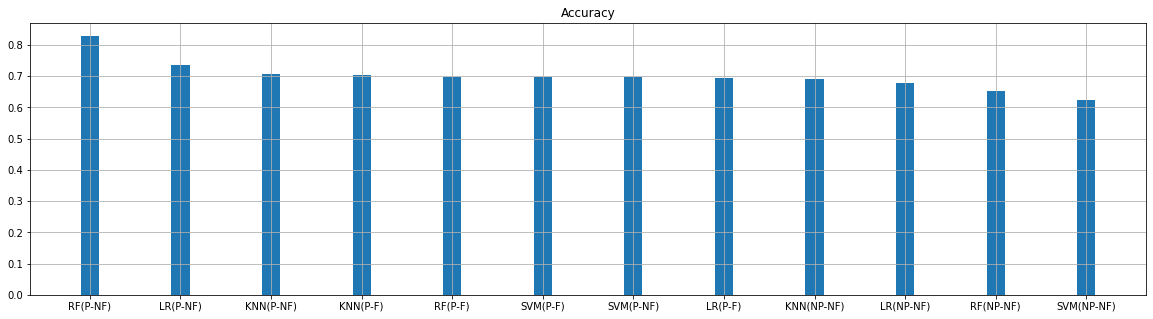

In [ ]:
plt.bar(df_accuracy_scores['name'], height=df_accuracy_scores['accuracy'], width=0.2)
plt.grid()
plt.title("Accuracy")
plt.show()

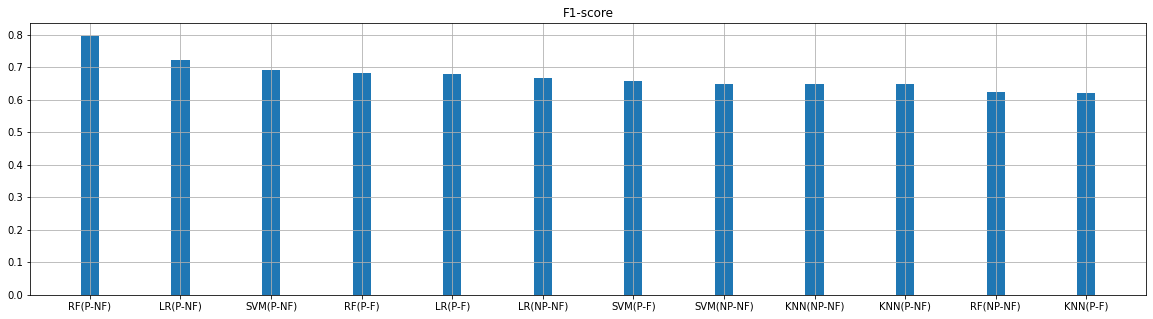

In [ ]:
plt.bar(df_f1_scores['name'], height=df_f1_scores['f1_score'], width=0.2)
plt.title("F1-score")
plt.grid()
plt.show()

Se observa que los modelos que no tienen feature selection tienen mas acc/f1 que los que si utilizan el metodo de feature selection. Esto puede deberse a que el feature selection limita mucho las features elegidas y al probarlo en un nuevo conjunto de datos (test) alguna feature de las eliminadas podria ser util. En caso de poseer mas datos podría considerarse mas certero el feature selection, pero en este caso donde los datos son escasos no es muy confiable. 

Podemos concluir en que el feature selection nos puede ayudar a reducir la cantidad de dimensiones (se realiza tambien tfidf marcando el min_df=30) y por ende a aumentar la interpretabilidad del algoritmo, ademas de aumentar la velocidad de entrenamiento. En este caso, en donde la velocidad de entrenamiento es tan baja solamente nos sirve para aumentar la interpretabilidad. A pesar de esto, el modelo que no utiliza feature selection otorga mejores resultados. Esto puede deberse a que se planteo un feature selection muy restrictivo y lo mejor sería plantear que permita más parámetros.

Para el tipo de problema y el pre procesamiento liviano que se aplico (no se usaron redes neuronales) un 0.83 de accuracy y 0.8 de f1-score es un valor muy elevado, dada la simplicidad del modelo. 